<img src='https://www.reliance-project.eu/wp-content/uploads/2021/03/Asset-8mdpi.svg' alt='Layout' align='left' width='25%'></img> 
<img src='https://media-exp1.licdn.com/dms/image/C560BAQFFDze0s3l-pQ/company-logo_200_200/0?e=2159024400&v=beta&t=jG_sh9NpwE6yc2TspIcL2YUR2X7OBzTrRSu6w7sNYtc' alt='Layout' align='right' width='10%'></img> 
<br>
<br>
<br>
<br>
<br>

# PM10 over Norway with CAMS European air quality analysis using RELIANCE services

## Analysis over a particular country and a town in the country of interest

<div class="alert alert-success alert-info">
<b>How to discover RELIANCE datacube resources (spatial & temporal search and subsetting), share resources using EGI datahub, and use RoHub to create FAIR digital Objects</b></div>

This notebook shows how to discover and access the [Copernicus Atmosphere Monitoring](https://ads.atmosphere.copernicus.eu/#!/home) products available in the **RELIANCE** datacube resources, by using the functionalities provided in the <font color='blue'> **Adam API** </font>. The process is structured in 7 steps, including example of data analysis and visualization with the Python libraries installed in the Jupyter environment as well as the creation of a FAIR digital object on [RoHUB](https://reliance.rohub.org/) where all the resources used and generated in this notebook are aggregated.

You can customize this Jupyter notebook, for instance by updating the content of [Data Management](#1.Data_Management) section.

- [1. Data Management](#1_Data_Management)
- [2. Authentication](#2_Authentication)
- [3. Datasets Discovery](#3_Datasets_Discovery)
- [4. Products Discovery](#4_Products_Discovery)
- [5. Data Access](#5_Data_Access)
- [6. Data Analysis and Visualizarion](#6_Data_Analysis_Visualization)
- [7. Create Research Object and Share my work](#7_rohub)

<a id=1_Data_Management></a>
## **Step 1: Data Management** 

### Authors 
- Make sure you first register to RoHub at [https://reliance.rohub.org/](https://reliance.rohub.org/). 
- We recommend you use your [ORCID](https://orcid.org/) identifier to login and register to EOSC services.
- In the list of authors, add any co-authors using the email address they used when they registered in RoHub.

In [1]:
author_emails = ['annefou@geo.uio.no', 'jeani@uio.no']

### Add the University of Olso and the Nordic e-Infrastructure Collaboration as publishers 

In [2]:
UiO_organization = {"org_id":"http://www.uio.no/english/", 
                     "display_name": "University of Oslo", 
                     "agent_type": "organization",
                     "ror_identifier":"01xtthb56",
                     "organization_url": "http://www.uio.no/english/"}

In [3]:
NeIC_organization = {"org_id":"https://neic.no/",
                    "display_name": "Nordic e-Infrastructure Collaboration", 
                     "agent_type": "organization",
                    "ror_identifier":"04jcwf484",
                    "organization_url": "https://neic.no/"}

In [4]:
list_publishers = [UiO_organization, NeIC_organization]

In [5]:
list_copyright_holders = [UiO_organization]

### Add the funding
- if your work is not funded set 
```
funded_by = {}
```

In [6]:
funded_by = {
"grant_id": "101017502",
"grant_Name": "RELIANCE",
"grant_title": "Research Lifecycle Management for Earth Science Communities and Copernicus Users",
"funder_name": "European Commission",
"funder_doi": "10.13039/501100000781",
}

### Choose a license for your FAIR digital object

In [7]:
import rohub

In [8]:
licenses = rohub.list_available_licenses()
# Update line below to print more licenses
licenses[0:5]

['0BSD', 'AAL', 'ADSL', 'AFL-1.1', 'AFL-1.2']

In [9]:
license = 'MIT'

### Organize my data using EGI datahub
- Define a prefix for my project (you may need to adjust it for your own usage on your infrastructure). 
   - `input` folder where all the data used as input to my Jupyter Notebook is stored (and eventually shared)
   - `output` folder where all the results to keep are stored
   - `tool` folder where all the tools, including this Jupyter Notebook will be copied for sharing
- Create all corresponding folders

### Import Python packages

In [10]:
import os
import warnings
import pathlib

In [11]:
warnings.filterwarnings('ignore')

## Initialization
- Choose a country and add its name and country code
- Choose the variable to analyze (PM10, PM25, NO2, O3, etc.)
- Choose the area for your analysis

### Choose the country of interest

In [12]:
country_code = 'NOR' 
country_fullname = "Norway"
town_fullname = 'Oslo'
town_coordinates = {'latitude': 59.9139, 'longitude': 10.7522}
variable_name = 'PM10'
variable_unit = 'µg m-3'
variable_long_name = 'Particulate matter < 10 µm'

### Geojson for selecting data from ADAM
- The geometry field is extracted from a GeoJSON file, retrieving the value of the "feature" element.
- To create a geojson file for the area of interest, you can use https://geojson.io/
- Then paste the result below in the geojson variable

In [13]:
geojson = """{"type":"FeatureCollection","crs":{"properties":{"name":"EPSG:3857"},"type":"name"}, "features": [{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[4.6036875426207855,59.5581642383661],[4.976893270578366,59.49612810369148],[5.187412395144024,59.51547857527121],[5.314694597630812,59.4754208020048],[5.46194995086779,59.4985804822173],[5.5509541464754415,59.56548073505248],[5.570844600145034,59.69533537110987],[5.687506238168163,59.68611201845158],[5.969568813873461,59.59766153318058],[6.183041740855596,59.58606579175937],[6.226443951603482,59.69208125871985],[6.328014657129806,59.78157736156505],[6.538058938703042,59.84284665652561],[6.685727323750598,59.8306273050048],[6.711753508713339,59.69419517333905],[6.977219446042791,59.77207134961575],[7.096287399116797,59.782776822428104],[7.110080241067353,59.70060347289024],[7.214666650262694,59.672686975162456],[7.098724290625119,59.65129363615313],[6.882833178432073,59.4284132222121],[6.831575654284099,59.31733043812738],[6.837700271297614,59.192589500999055],[6.903688867536173,59.1134031625063],[6.665525573243108,58.98537452132439],[6.518096299731733,58.767413137599135],[6.622800782192264,58.70404660102872],[6.582724331216928,58.61524989236232],[6.630154415569601,58.443725846760806],[6.560330428978365,58.327403214636526],[6.372950593663838,58.27650740920263],[6.149704902213886,58.02785083245],[5.623018821983156,58.27372489071853],[5.32732362005283,58.45606833522307],[5.1862370630256995,58.59092712355939],[5.005934259268686,58.92314962125401],[4.8951624493395585,59.000641678613654],[4.612568086643404,59.1120155487895],[4.487336084360328,59.19559531997406],[4.48351174940575,59.36888980343831],[4.6036875426207855,59.5581642383661]]]},"properties":{"objtype":"Fylke","opphav":null,"samiskforvaltningsomrade":false,"versjonid":"4.1","navn":[{"sprak":"nor","rekkefolge":"","navn":"Rogaland"}],"lokalid":"173152","datafangstdato":null,"oppdateringsdato":null,"datauttaksdato":"20191220110418","fylkesnummer":"11","navnerom":"http://skjema.geonorge.no/SOSI/produktspesifikasjon/AdmEnheter/4.1"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[7.214666650262694,59.672686975162456],[7.110080241067353,59.70060347289024],[7.096287399116797,59.782776822428104],[7.232910870712491,59.9627143347557],[7.436428801336992,60.01922769790947],[7.4882617498640744,60.098929288990774],[7.646000588794798,60.126852020758506],[7.812840509060449,60.10265102536176],[8.104126000477166,60.18378638020944],[8.486105719256143,60.168794447844085],[8.722863576459371,60.183106927322804],[8.945002575144864,60.10058207385818],[8.98985963127968,60.01268548621087],[9.192594395240505,59.9168137732459],[9.18608850828882,59.826987399144095],[9.32955571284026,59.79401961814668],[9.471983680397132,59.55735449359721],[9.660119707239595,59.40787093047277],[9.819112470812565,59.46918378857228],[10.059967600742764,59.47302910384062],[9.92124767093519,59.58253893421675],[10.115514598361628,59.67066715256403],[10.302943686629977,59.66824167931412],[10.344232110850955,59.56349467470484],[10.584161857567087,59.39306382470963],[10.590331585006044,59.26848324610236],[10.655050150731858,59.191957592148405],[10.675019827881227,59.045287940377804],[10.593095157870472,58.76096038573373],[10.27091989388847,58.77502633666313],[10.073833377589374,58.74791928695044],[9.788358204228302,58.67227869592126],[9.668876552903514,58.6033108398088],[9.353877934682947,58.77681903951917],[9.196343144881196,58.80344610186381],[9.160531188384978,58.884960020905844],[8.99488366557004,58.99322716873493],[8.834176047751148,58.98808791604636],[8.830738162108117,58.912573761967195],[8.72353073936887,58.84980977196661],[8.564888145088261,58.92712684981595],[8.47645974649465,58.886905305225305],[8.173291568044283,58.982337320164085],[7.9853268379970554,58.96163422780526],[7.73043904687936,59.16339767671192],[7.757843518240594,59.228451858993346],[7.696159019978706,59.32674804154754],[7.539958376843031,59.398818840629055],[7.625632926832078,59.461783560870124],[7.551555950015539,59.586624700040815],[7.214666650262694,59.672686975162456]]]},"properties":{"objtype":"Fylke","opphav":null,"samiskforvaltningsomrade":false,"versjonid":"4.1","navn":[{"sprak":"nor","rekkefolge":"","navn":"Vestfold og Telemark"}],"lokalid":"173158173162","datafangstdato":null,"oppdateringsdato":"20190913000000","datauttaksdato":"20191220110420","fylkesnummer":"38","navnerom":"http://skjema.geonorge.no/SOSI/produktspesifikasjon/AdmEnheter/4.1"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[16.25435079984699,69.59670059339743],[16.517643404716573,69.41551211656854],[16.312621892342055,69.16592251205839],[16.052313806898393,69.00862947141754],[16.11226698060729,68.93178451578264],[15.94727188319379,68.85124956031792],[16.045701672755904,68.75783802441784],[15.650071854504482,68.62307645873864],[15.60839658451443,68.56324720195462],[15.756464632957057,68.49212625386981],[15.962338153751851,68.6138975505372],[16.05200874160143,68.53021280103349],[16.040450518417288,68.42240096031644],[16.16215339046912,68.37208439548212],[16.56766710606881,68.43426140542591],[16.866878883425354,68.57276561219825],[17.195537135269515,68.55747598297444],[17.547589369885582,68.59700848490196],[18.023286541945147,68.6084547258158],[18.125923576593628,68.53651470757535],[18.101091513432863,68.40604299993866],[18.151354895183847,68.1987893553204],[17.899762665031894,67.96937037553533],[17.281524478786984,68.11881456096545],[17.180507609216473,68.05045941132516],[16.738120161385893,67.9142104239841],[16.556285010152724,67.64719273998497],[16.4075678027176,67.5340260490341],[16.158001925775128,67.51915787685171],[16.089829849654386,67.4352783222892],[16.404099819135535,67.20497337808274],[16.387759275817437,67.04546130889216],[16.03876189547061,66.91244708440195],[15.621368715227186,66.59433537222856],[15.377226873879788,66.48430530696814],[15.484732311890602,66.282459121907],[15.035682668202924,66.15355669781894],[14.516289808652726,66.13257827937542],[14.625477676332546,65.81180736567977],[14.5414696246882,65.70075178305022],[14.49877296116551,65.52129703674343],[14.506831554618369,65.30972858364363],[14.37879810416888,65.24761968665581],[14.325985837453887,65.11891514981413],[14.164296948907745,65.13924894897147],[13.41124982806865,65.09907800796418],[13.152544842072658,65.11587821690404],[12.995960108821512,65.0684489472268],[12.906963963680157,64.97424882019499],[12.628669435623651,64.93949726689814],[12.561257230852613,64.9903112463098],[12.180828343764645,64.9822967317334],[11.960207336540124,65.11682244779803],[11.48604840313997,65.23685779549837],[11.400403170954768,65.2957033546197],[11.021360867208363,65.39442845690058],[10.578060311224872,65.4701750005549],[10.79868259726831,65.70181048650433],[11.093268668018213,66.1997398920816],[11.565975442785593,66.66770172886798],[11.85883469924428,66.81537147979243],[11.359172085058486,67.33105233669455],[11.306784347919232,67.45533260430221],[11.507000699616624,67.63086281566079],[12.128473662203048,67.82279783461391],[12.305893785126578,68.0313083915745],[12.58416736649014,68.23572784062306],[12.83252860106863,68.34643915902959],[13.263980806437868,68.4635555225324],[13.72163202201636,68.74621474072062],[13.891909427164286,68.87260761486199],[14.73370268545496,69.23144482039497],[15.69859656804887,69.49800509785935],[16.25435079984699,69.59670059339743]]]},"properties":{"objtype":"Fylke","opphav":null,"oppdateringsdato":null,"versjonid":"4.1","navn":[{"sprak":"nor","rekkefolge":"","navn":"Nordland"}],"lokalid":"173144","datafangstdato":null,"fylkesnummer":"18","datauttaksdato":"20191220110420","navnerom":"http://skjema.geonorge.no/SOSI/produktspesifikasjon/AdmEnheter/4.1"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[7.214666650262694,59.672686975162456],[7.551555950015539,59.586624700040815],[7.625632926832078,59.461783560870124],[7.539958376843031,59.398818840629055],[7.696159019978706,59.32674804154754],[7.757843518240594,59.228451858993346],[7.73043904687936,59.16339767671192],[7.9853268379970554,58.96163422780526],[8.173291568044283,58.982337320164085],[8.47645974649465,58.886905305225305],[8.564888145088261,58.92712684981595],[8.72353073936887,58.84980977196661],[8.830738162108117,58.912573761967195],[8.834176047751148,58.98808791604636],[8.99488366557004,58.99322716873493],[9.160531188384978,58.884960020905844],[9.196343144881196,58.80344610186381],[9.353877934682947,58.77681903951917],[9.668876552903514,58.6033108398088],[8.94247132638619,58.17581351545791],[8.50587677376413,57.960981971021404],[8.16304783946329,57.86488319268867],[7.693071695267515,57.76635296308362],[7.130630207714567,57.76582648945614],[6.8632906668540885,57.7989820580147],[6.4060428635448705,57.90825582577116],[6.149704902213886,58.02785083245],[6.372950593663838,58.27650740920263],[6.560330428978365,58.327403214636526],[6.630154415569601,58.443725846760806],[6.582724331216928,58.61524989236232],[6.622800782192264,58.70404660102872],[6.518096299731733,58.767413137599135],[6.665525573243108,58.98537452132439],[6.903688867536173,59.1134031625063],[6.837700271297614,59.192589500999055],[6.831575654284099,59.31733043812738],[6.882833178432073,59.4284132222121],[7.098724290625119,59.65129363615313],[7.214666650262694,59.672686975162456]]]},"properties":{"objtype":"Fylke","opphav":null,"samiskforvaltningsomrade":false,"versjonid":"4.1","navn":[{"sprak":"nor","rekkefolge":"","navn":"Agder"}],"lokalid":"173153173160","datafangstdato":null,"oppdateringsdato":"20190301000000","datauttaksdato":"20191220110421","fylkesnummer":"42","navnerom":"http://skjema.geonorge.no/SOSI/produktspesifikasjon/AdmEnheter/4.1"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[7.349109216493669,62.007681894512814],[7.734595489016545,62.184633181976004],[7.983609909673337,62.177458831341184],[8.205852119942362,62.33174420038932],[8.38932467363444,62.363869263818785],[9.062061789315829,62.37260842221783],[9.601920978479576,62.255726729172466],[9.801854148958427,62.28901106243122],[9.839302390776712,62.36208821459702],[10.097583077440769,62.42780772375924],[10.00573180883309,62.55813255947697],[10.176474926881466,62.69692794159545],[10.592832508100594,62.66381116267349],[10.928247934715623,62.696295682128486],[11.160792203264045,62.64741871985782],[11.254249228537466,62.53248644113113],[11.428893682436048,62.479845031004125],[11.565614074161617,62.37067972676412],[11.76616628136462,62.3817214168537],[12.254665262295756,62.33102492413106],[12.29937086128288,62.26749595877163],[12.137665883055547,61.723817606849316],[12.419609782477773,61.5629807718864],[12.569317601787832,61.568746582183806],[12.870848559881424,61.35649635251255],[12.790349320765866,61.197046397611096],[12.682583552470549,61.061219466408936],[12.447614399288911,61.05072902174291],[12.223991558106441,61.01307795970549],[12.33279043185223,60.89017213941699],[12.395371157360037,60.73388667482424],[12.606882969812988,60.51274204539624],[12.606054238164333,60.405925811852654],[12.498795718428452,60.32365328320896],[12.541906213924982,60.19337726051371],[12.44855903277107,60.03917691111703],[12.174292518545043,59.88981061832951],[11.941725778772966,59.88999890024824],[11.839714685757867,59.84078459855589],[11.778080501748937,60.08973760364976],[11.560127458885068,60.18158501273674],[11.601894849206287,60.26728733681006],[11.432605392639449,60.339613834227734],[11.342259003731991,60.45879848158249],[11.067134018254093,60.51866814854459],[10.720285577224189,60.434341940875896],[10.90310940622509,60.39629218196077],[10.864739185858378,60.3139249247696],[10.719849629969152,60.32953027108271],[10.366275893483188,60.32097531428768],[10.194272699477928,60.40030955088629],[10.154282387638784,60.524769165629195],[10.035329874477489,60.632055005616344],[9.810480847178113,60.556087781081494],[9.830499229883069,60.45642283113913],[9.478694766702203,60.530145524259225],[9.319451344003445,60.68190299272416],[9.332110104958202,60.729904214566126],[9.14690676849725,60.80683103984089],[8.693490926677253,60.92543014454304],[8.50949221570074,61.018407973397586],[8.251701165718726,61.07394382617299],[8.143933254877647,61.10958902760619],[8.050932657695864,61.21175335568934],[8.251450187444656,61.33439315748754],[8.150360455995864,61.42674140781284],[8.322052971518882,61.45588543251621],[8.262332621231877,61.53397957718565],[8.117893392392423,61.522846777540735],[7.947312429988986,61.556680681148116],[7.908215486311291,61.72167919917975],[7.752518560662816,61.75481002851276],[7.513823662902068,61.72736446998578],[7.412503204858362,61.85750942402648],[7.349109216493669,62.007681894512814]]]},"properties":{"objtype":"Fylke","opphav":null,"samiskforvaltningsomrade":false,"versjonid":"4.1","navn":[{"sprak":"nor","rekkefolge":"","navn":"Innlandet"}],"lokalid":"173154173155","datafangstdato":null,"oppdateringsdato":"20190225000000","datauttaksdato":"20191220110421","fylkesnummer":"34","navnerom":"http://skjema.geonorge.no/SOSI/produktspesifikasjon/AdmEnheter/4.1"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[7.648093890798479,63.768167724951994],[8.108651561020618,63.59814741995014],[8.240533152702374,63.42209247011288],[8.342934303956618,63.359413523807255],[8.742727377525458,63.44748109920632],[8.904581632098163,63.34883346493022],[8.81574866310206,63.26612643210208],[8.833267813875391,63.198838284351076],[8.482864588780027,63.149669585646464],[8.150059793635165,63.14304228305024],[8.243706084482346,63.01208419577288],[8.481498386670921,63.07965039527113],[8.688717018392111,63.07339925037408],[8.80715264267274,63.12661736073491],[8.96995848795693,63.133918964349725],[9.083745583872512,63.09038725844047],[9.136315473187878,62.92723087399356],[9.266733068284779,62.92582962403502],[9.323551392083406,62.809450177459645],[8.91996200923797,62.71177086185585],[9.15429139279693,62.57285019165097],[9.243729871275756,62.55607781309883],[9.18362559650991,62.42664568085227],[9.062061789315829,62.37260842221783],[8.38932467363444,62.363869263818785],[8.205852119942362,62.33174420038932],[7.983609909673337,62.177458831341184],[7.734595489016545,62.184633181976004],[7.349109216493669,62.007681894512814],[7.082810204334512,62.00571859018056],[6.706498505975514,61.953045672949884],[6.4326541773789465,61.95074908101019],[6.1818334897670555,62.01065368915462],[6.036361205102313,61.956583594769086],[5.926908990938698,61.996594821720784],[5.551558852539754,61.96041235171243],[5.503090007020898,62.06673615642628],[5.217879396325422,62.26120001813496],[4.816601148640049,62.38239573239974],[4.949089302626774,62.47193482455205],[5.963660169464204,62.961801316633924],[6.838929066220142,63.259797614745786],[7.648093890798479,63.768167724951994]]]},"properties":{"objtype":"Fylke","opphav":null,"samiskforvaltningsomrade":false,"versjonid":"4.1","navn":[{"sprak":"nor","rekkefolge":"","navn":"Møre og Romsdal"}],"lokalid":"173147","datafangstdato":null,"oppdateringsdato":null,"datauttaksdato":"20191220110422","fylkesnummer":"15","navnerom":"http://skjema.geonorge.no/SOSI/produktspesifikasjon/AdmEnheter/4.1"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[4.816601148640049,62.38239573239974],[5.217879396325422,62.26120001813496],[5.503090007020898,62.06673615642628],[5.551558852539754,61.96041235171243],[5.926908990938698,61.996594821720784],[6.036361205102313,61.956583594769086],[6.1818334897670555,62.01065368915462],[6.4326541773789465,61.95074908101019],[6.706498505975514,61.953045672949884],[7.082810204334512,62.00571859018056],[7.349109216493669,62.007681894512814],[7.412503204858362,61.85750942402648],[7.513823662902068,61.72736446998578],[7.752518560662816,61.75481002851276],[7.908215486311291,61.72167919917975],[7.947312429988986,61.556680681148116],[8.117893392392423,61.522846777540735],[8.262332621231877,61.53397957718565],[8.322052971518882,61.45588543251621],[8.150360455995864,61.42674140781284],[8.251450187444656,61.33439315748754],[8.050932657695864,61.21175335568934],[8.143933254877647,61.10958902760619],[8.251701165718726,61.07394382617299],[8.040872298960727,60.89321496104569],[7.8030270731334666,60.896734539714316],[7.704431979337082,60.79277215466441],[7.438842391703543,60.6600393507578],[7.635850738217771,60.63290696647603],[7.732114689080657,60.52097048980868],[7.6737090274534605,60.294334811797704],[7.4882617498640744,60.098929288990774],[7.436428801336992,60.01922769790947],[7.232910870712491,59.9627143347557],[7.096287399116797,59.782776822428104],[6.977219446042791,59.77207134961575],[6.711753508713339,59.69419517333905],[6.685727323750598,59.8306273050048],[6.538058938703042,59.84284665652561],[6.328014657129806,59.78157736156505],[6.226443951603482,59.69208125871985],[6.183041740855596,59.58606579175937],[5.969568813873461,59.59766153318058],[5.687506238168163,59.68611201845158],[5.570844600145034,59.69533537110987],[5.5509541464754415,59.56548073505248],[5.46194995086779,59.4985804822173],[5.314694597630812,59.4754208020048],[5.187412395144024,59.51547857527121],[4.976893270578366,59.49612810369148],[4.6036875426207855,59.5581642383661],[4.672072489292118,59.664958775121356],[4.493933303098539,60.27221719483768],[4.104081313789186,60.976195898483915],[4.087977418152047,61.08376192967021],[4.147660254478282,61.66170119339135],[4.177748330315141,61.72644915913622],[4.667030031849028,62.27066904187206],[4.816601148640049,62.38239573239974]]]},"properties":{"objtype":"Fylke","opphav":null,"samiskforvaltningsomrade":false,"versjonid":"4.1","navn":[{"sprak":"nor","rekkefolge":"","navn":"Vestland"}],"lokalid":"173150173151","datafangstdato":null,"oppdateringsdato":null,"datauttaksdato":"20191220110422","fylkesnummer":"46","navnerom":"http://skjema.geonorge.no/SOSI/produktspesifikasjon/AdmEnheter/4.1"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[10.618176216104347,59.970512126808615],[10.489165172838884,60.017259872374645],[10.603949181472967,60.1338597770426],[10.73711867703991,60.125733600579316],[10.811720634337512,60.02561911878851],[10.945976341262156,59.94322033835645],[10.88029688872709,59.81138930328435],[10.658082484659966,59.884410483442366],[10.618176216104347,59.970512126808615]]]},"properties":{"objtype":"Fylke","opphav":null,"samiskforvaltningsomrade":false,"versjonid":"4.1","navn":[{"sprak":"nor","rekkefolge":"","navn":"Oslo"}],"lokalid":"173159","datafangstdato":null,"oppdateringsdato":null,"datauttaksdato":"20191220110422","fylkesnummer":"03","navnerom":"http://skjema.geonorge.no/SOSI/produktspesifikasjon/AdmEnheter/4.1"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[7.4882617498640744,60.098929288990774],[7.6737090274534605,60.294334811797704],[7.732114689080657,60.52097048980868],[7.635850738217771,60.63290696647603],[7.438842391703543,60.6600393507578],[7.704431979337082,60.79277215466441],[7.8030270731334666,60.896734539714316],[8.040872298960727,60.89321496104569],[8.251701165718726,61.07394382617299],[8.50949221570074,61.018407973397586],[8.693490926677253,60.92543014454304],[9.14690676849725,60.80683103984089],[9.332110104958202,60.729904214566126],[9.319451344003445,60.68190299272416],[9.478694766702203,60.530145524259225],[9.830499229883069,60.45642283113913],[9.810480847178113,60.556087781081494],[10.035329874477489,60.632055005616344],[10.154282387638784,60.524769165629195],[10.194272699477928,60.40030955088629],[10.366275893483188,60.32097531428768],[10.719849629969152,60.32953027108271],[10.864739185858378,60.3139249247696],[10.90310940622509,60.39629218196077],[10.720285577224189,60.434341940875896],[11.067134018254093,60.51866814854459],[11.342259003731991,60.45879848158249],[11.432605392639449,60.339613834227734],[11.601894849206287,60.26728733681006],[11.560127458885068,60.18158501273674],[11.778080501748937,60.08973760364976],[11.839714685757867,59.84078459855589],[11.926022144863493,59.79399950803483],[11.939877897133663,59.69457981479818],[11.691128335383578,59.58954865035213],[11.816245151332136,59.34474444656028],[11.775000614600462,59.08635848798452],[11.63130558632842,58.90864043956445],[11.460683666954116,58.88965608589195],[11.464598196582852,58.991152057733295],[11.368410030449189,59.098436627848976],[11.153506179763205,59.07925679684325],[11.066417444904939,58.97739441860367],[10.638923751193252,58.892275787544065],[10.593095157870472,58.76096038573373],[10.675019827881227,59.045287940377804],[10.655050150731858,59.191957592148405],[10.590331585006044,59.26848324610236],[10.584161857567087,59.39306382470963],[10.344232110850955,59.56349467470484],[10.302943686629977,59.66824167931412],[10.115514598361628,59.67066715256403],[9.92124767093519,59.58253893421675],[10.059967600742764,59.47302910384062],[9.819112470812565,59.46918378857228],[9.660119707239595,59.40787093047277],[9.471983680397132,59.55735449359721],[9.32955571284026,59.79401961814668],[9.18608850828882,59.826987399144095],[9.192594395240505,59.9168137732459],[8.98985963127968,60.01268548621087],[8.945002575144864,60.10058207385818],[8.722863576459371,60.183106927322804],[8.486105719256143,60.168794447844085],[8.104126000477166,60.18378638020944],[7.812840509060449,60.10265102536176],[7.646000588794798,60.126852020758506],[7.4882617498640744,60.098929288990774]],[[10.618176216104347,59.970512126808615],[10.658082484659966,59.884410483442366],[10.88029688872709,59.81138930328435],[10.945976341262156,59.94322033835645],[10.811720634337512,60.02561911878851],[10.73711867703991,60.125733600579316],[10.603949181472967,60.1338597770426],[10.489165172838884,60.017259872374645],[10.618176216104347,59.970512126808615]]]},"properties":{"objtype":"Fylke","opphav":null,"samiskforvaltningsomrade":false,"versjonid":"4.1","navn":[{"sprak":"nor","rekkefolge":"","navn":"Viken"}],"lokalid":"173157173156173161","datafangstdato":null,"oppdateringsdato":"20190225000000","datauttaksdato":"20191220110424","fylkesnummer":"30","navnerom":"http://skjema.geonorge.no/SOSI/produktspesifikasjon/AdmEnheter/4.1"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[10.578060311224872,65.4701750005549],[11.021360867208363,65.39442845690058],[11.400403170954768,65.2957033546197],[11.48604840313997,65.23685779549837],[11.960207336540124,65.11682244779803],[12.180828343764645,64.9822967317334],[12.561257230852613,64.9903112463098],[12.628669435623651,64.93949726689814],[12.906963963680157,64.97424882019499],[12.995960108821512,65.0684489472268],[13.152544842072658,65.11587821690404],[13.41124982806865,65.09907800796418],[14.164296948907745,65.13924894897147],[14.325985837453887,65.11891514981413],[13.705473168169396,64.63995683003515],[13.654259625547281,64.58034097411506],[14.113871619032558,64.46248276393027],[14.1571100920417,64.19505543508804],[13.96752672054242,64.0079703922938],[13.211109667100082,64.09536682525807],[12.926718801855394,64.05795219714233],[12.68356811761007,63.974222248731266],[12.149770693016858,63.59394499988306],[12.212878328336561,63.47859055888195],[11.97458217609219,63.269225248480105],[12.21823295751056,63.000334468170536],[12.074688981038618,62.90254629651037],[12.136384549870208,62.74791694389485],[12.05614400473314,62.61191913728687],[12.254665262295756,62.33102492413106],[11.76616628136462,62.3817214168537],[11.565614074161617,62.37067972676412],[11.428893682436048,62.479845031004125],[11.254249228537466,62.53248644113113],[11.160792203264045,62.64741871985782],[10.928247934715623,62.696295682128486],[10.592832508100594,62.66381116267349],[10.176474926881466,62.69692794159545],[10.00573180883309,62.55813255947697],[10.097583077440769,62.42780772375924],[9.839302390776712,62.36208821459702],[9.801854148958427,62.28901106243122],[9.601920978479576,62.255726729172466],[9.062061789315829,62.37260842221783],[9.18362559650991,62.42664568085227],[9.243729871275756,62.55607781309883],[9.15429139279693,62.57285019165097],[8.91996200923797,62.71177086185585],[9.323551392083406,62.809450177459645],[9.266733068284779,62.92582962403502],[9.136315473187878,62.92723087399356],[9.083745583872512,63.09038725844047],[8.96995848795693,63.133918964349725],[8.80715264267274,63.12661736073491],[8.688717018392111,63.07339925037408],[8.481498386670921,63.07965039527113],[8.243706084482346,63.01208419577288],[8.150059793635165,63.14304228305024],[8.482864588780027,63.149669585646464],[8.833267813875391,63.198838284351076],[8.81574866310206,63.26612643210208],[8.904581632098163,63.34883346493022],[8.742727377525458,63.44748109920632],[8.342934303956618,63.359413523807255],[8.240533152702374,63.42209247011288],[8.108651561020618,63.59814741995014],[7.648093890798479,63.768167724951994],[8.164648790975804,64.06632195421744],[8.94047592435967,64.35771217125506],[9.996956454109926,64.86981495639407],[10.089369697728307,64.99272151846519],[10.578060311224872,65.4701750005549]]]},"properties":{"objtype":"Fylke","opphav":null,"oppdateringsdato":null,"versjonid":"4.1","navn":[{"sprak":"nor","rekkefolge":"1","navn":"Trøndelag"},{"sprak":"sma","rekkefolge":"2","navn":"Trööndelage"}],"lokalid":"173146173145","datafangstdato":null,"fylkesnummer":"50","datauttaksdato":"20191220110424","navnerom":"http://skjema.geonorge.no/SOSI/produktspesifikasjon/AdmEnheter/4.1"}},
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[18.125923576593628,68.53651470757535],[18.023286541945147,68.6084547258158],[17.547589369885582,68.59700848490196],[17.195537135269515,68.55747598297444],[16.866878883425354,68.57276561219825],[16.56766710606881,68.43426140542591],[16.16215339046912,68.37208439548212],[16.040450518417288,68.42240096031644],[16.05200874160143,68.53021280103349],[15.962338153751851,68.6138975505372],[15.756464632957057,68.49212625386981],[15.60839658451443,68.56324720195462],[15.650071854504482,68.62307645873864],[16.045701672755904,68.75783802441784],[15.94727188319379,68.85124956031792],[16.11226698060729,68.93178451578264],[16.052313806898393,69.00862947141754],[16.312621892342055,69.16592251205839],[16.517643404716573,69.41551211656854],[16.25435079984699,69.59670059339743],[17.055514517979923,69.74504305736492],[17.45368235913804,69.99391672304476],[18.213605198861313,70.36124715655679],[18.853201994322905,70.48804647728151],[21.701190724569685,70.85297424331144],[22.476382823473656,71.02705678501304],[23.644575413213502,71.26595668499182],[24.016326410026167,71.30081364867962],[24.629253479649215,71.31408496929268],[25.715161656640912,71.38448003367628],[27.71778945603133,71.33228199539214],[28.299638623166366,71.29683086110707],[28.555627033282065,71.26230020797256],[29.566169705070035,71.02360772051858],[30.38108223210084,70.88251263343177],[30.613583232171177,70.8253767452661],[31.54880106057498,70.54527582261365],[31.753975862991858,70.42014974674709],[31.752263995508272,70.35258879832543],[31.58558627481637,70.14375032361649],[31.10432780961691,69.97930278009648],[30.817641187435495,69.79484440063035],[30.946269227889008,69.67812603016263],[30.938986205350492,69.56106787606028],[30.803478524759505,69.52886023924356],[30.515981049913904,69.54042062365073],[30.22402894120277,69.65312054139156],[30.117573203270883,69.46985570991076],[29.850497033846466,69.42281259584675],[29.573610259983575,69.31869818999964],[29.291454764073062,69.29764807718286],[29.242136873622577,69.11301855910577],[29.056653725917666,69.0152254946494],[28.80543005069157,69.11115589326275],[28.831539081434748,69.22436171827408],[29.219339459891657,69.39763620917176],[29.336495624737022,69.47832270473464],[29.133909469528074,69.69534041857234],[28.404225479500454,69.81842497108627],[27.984285298081577,70.01397068243033],[27.959381641040377,70.09209972587301],[27.61598664612834,70.07499752767812],[27.305483521200703,69.9580499316255],[27.031612686569193,69.91079246236166],[26.67607945345128,69.96462004618007],[26.46663282103355,69.9401961702688],[26.360643970199842,69.84481252175232],[25.897101720235874,69.65917794652823],[25.976571164405524,69.61104224783688],[25.876070324340713,69.52899686262128],[25.693639824785365,69.20363423498932],[25.777441206000017,69.01828027766051],[25.62814490895838,68.89330517169857],[25.48158711333353,68.90505815861955],[25.157126599967917,68.79989291752443],[25.076335180027364,68.6222038819142],[24.91692407296744,68.60524660281506],[24.60838794846567,68.68190160286608],[24.302260042118714,68.71735026293757],[23.9833308287638,68.82714342723078],[23.775391560870712,68.8188512740247],[23.673520265082,68.70552133208528],[23.440635570038683,68.69216348814946],[23.167582270204573,68.62851889802187],[23.04595226768206,68.6893435368137],[22.800824148243684,68.68754812915934],[22.535389409272646,68.74451263501416],[22.374521945301392,68.7166665337093],[22.34078069989356,68.82722565145016],[22.17576250038662,68.95632435213317],[21.627086473226424,69.27658826405947],[21.278821101791273,69.3118841275669],[20.98757519505446,69.19192745614615],[21.108675084862345,69.10392915927528],[21.05754394632232,69.0362896707933],[20.717322287879004,69.11979130006014],[20.552327464237774,69.06007679820686],[20.06004720214723,69.04575780910712],[20.306589550385493,68.92618235071241],[20.33587305684839,68.80231445153865],[20.202834994079954,68.66592384366338],[19.937503990757282,68.55794179653603],[20.226543808176217,68.49081438841164],[19.921397091945877,68.35601380296988],[18.983802149426225,68.51696323733212],[18.621223955596,68.50695764739868],[18.405689293718375,68.58187751291199],[18.125923576593628,68.53651470757535]]]},"properties":{"objtype":"Fylke","opphav":null,"oppdateringsdato":null,"versjonid":"4.1","navn":[{"sprak":"nor","rekkefolge":"1","navn":"Troms og Finnmark"},{"sprak":"fkv","rekkefolge":"3","navn":"Tromssa ja Finmarkku"},{"sprak":"sme","rekkefolge":"2","navn":"Romsa ja Finnmárku"}],"lokalid":"173143173142","datafangstdato":null,"fylkesnummer":"54","datauttaksdato":"20191220110424","navnerom":"http://skjema.geonorge.no/SOSI/produktspesifikasjon/AdmEnheter/4.1"}}]}"""

### Create folders

In [14]:
WORKDIR_FOLDER = os.path.join(os.environ['HOME'], "datahub/Reliance/Climate" + '_' + country_code + '_' + variable_name)
print("WORKDIR FOLDER: ", WORKDIR_FOLDER)

WORKDIR FOLDER:  /home/jovyan/datahub/Reliance/Climate_NOR_PM10


In [15]:
INPUT_DATA_DIR = os.path.join(WORKDIR_FOLDER, 'input')
OUTPUT_DATA_DIR = os.path.join(WORKDIR_FOLDER, 'output')
TOOL_DATA_DIR = os.path.join(WORKDIR_FOLDER, 'tool')

list_folders = [INPUT_DATA_DIR, OUTPUT_DATA_DIR, TOOL_DATA_DIR]

for folder in list_folders:
    pathlib.Path(folder).mkdir(parents=True, exist_ok=True)

### Geojson for selecting data from ADAM
- We dissolve geojson in case we have more than one polygon and then save the results into a geojson file

In [16]:
import geopandas as gpd

In [17]:
local_path_geom = os.path.join(INPUT_DATA_DIR, country_code.lower() + '.geo.json')
local_path_geom

'/home/jovyan/datahub/Reliance/Climate_NOR_PM10/input/nor.geo.json'

In [18]:
if (pathlib.Path(local_path_geom).exists()):
    os.remove(local_path_geom)
f = open(local_path_geom, "w")
f.write(geojson)
f.close()

In [19]:
data = gpd.read_file(local_path_geom)

In [20]:
single_shape = data.dissolve()

### Show area of interest

<AxesSubplot:>

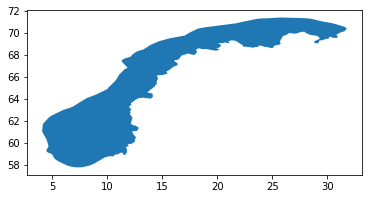

In [21]:
single_shape.plot()

In [22]:
if (pathlib.Path(local_path_geom).exists()):
    os.remove(local_path_geom)

In [23]:
single_shape.to_file(local_path_geom, driver='GeoJSON')

## <a id=2_Authentication></a> **Step 2: Authentication** 

The following lines of code will show the personal **Adam API-Key** of the user and the endpoint currently in use, that provides access to the products in the related catalogue. At the end of the execution, if the authentication process is successfull the personal token and the expiration time should be returned as outputs.

In [24]:
pip install adamapi

Note: you may need to restart the kernel to use updated packages.


In [25]:
adam_key = open(os.path.join(os.environ['HOME'],"adam-key")).read().rstrip()

In [26]:
import adamapi as adam
a = adam.Auth()

a.setKey(adam_key)
a.setAdamCore('https://reliance.adamplatform.eu')
a.authorize() 

{'expires_at': '2022-01-23T21:56:29.582Z',
 'access_token': '122122f1f6ea487392611cddef778ca4',
 'refresh_token': '3cdd00cd2e654faebaec60b019412223',
 'expires_in': 3600}

## <a id=3_Datasets_Discovery></a> **Step 3: Datasets Discovery**

After authorization, the user can browse the whole catalogue, structured as a JSON object after a pagination process,  displaying all the available datasets. This operation can be executed with the <font color='blue'> **getDatasets()** </font> function without including any argument. Some lines of code should be added to parse the Json object and extract the names of the datasets.The Json object can be handled as a Python dictionary.

### Pre-filter datasets

We will discover all the available datasets in the ADAM platform but will only print elements of interest **EU_CAMS** e.g. [European air quality datasets](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) from Copernicus Atmosphere Monitoring Service

In [27]:
def list_datasets(a, search="", dataset_name=""):
    datasets = adam.Datasets(a)
    catalogue = datasets.getDatasets()
    datasetID = None

# Extracting the size of the catalogue

    total = catalogue['properties']['totalResults']
    items = catalogue['properties']['itemsPerPage']
    pages = total // items
    
    print('\033[1;34m')
    print('----------------------------------------------------------------------')
    print( 'List of available datasets:')
    print ('\033[0;0m')

# Extracting the list of datasets across the whole catalogue

    for i in range(0, pages):
        page = datasets.getDatasets(page=i)
        for element in page['content']:
            if search == "" or search in element['title']:
                print(element['title'] + " --> datasetId = " + element['datasetId'])
                if element['title'] == dataset_name:
                    datasetID = element['datasetId']
    return datasets, datasetID

In [28]:
datasets, datasetID = list_datasets(a, search="EU_CAMS", dataset_name = 'EU_CAMS_SURFACE_' + variable_name + '_G')


----------------------------------------------------------------------
List of available datasets:

EU_CAMS_SURFACE_C2H3NO5_G --> datasetId = 69619:EU_CAMS_SURFACE_C2H3NO5_G
EU_CAMS_SURFACE_CO_G --> datasetId = 69620:EU_CAMS_SURFACE_CO_G
EU_CAMS_SURFACE_NH3_G --> datasetId = 69621:EU_CAMS_SURFACE_NH3_G
EU_CAMS_SURFACE_NMVOC_G --> datasetId = 69622:EU_CAMS_SURFACE_NMVOC_G
EU_CAMS_SURFACE_NO2_G --> datasetId = 69623:EU_CAMS_SURFACE_NO2_G
EU_CAMS_SURFACE_NO_G --> datasetId = 69624:EU_CAMS_SURFACE_NO_G
EU_CAMS_SURFACE_O3_G --> datasetId = 69625:EU_CAMS_SURFACE_O3_G
EU_CAMS_SURFACE_PM10_G --> datasetId = 69626:EU_CAMS_SURFACE_PM10_G
EU_CAMS_SURFACE_PM25_G --> datasetId = 69627:EU_CAMS_SURFACE_PM25_G
EU_CAMS_SURFACE_REC_G --> datasetId = 69628:EU_CAMS_SURFACE_REC_G
EU_CAMS_SURFACE_SIA_G --> datasetId = 69629:EU_CAMS_SURFACE_SIA_G
EU_CAMS_SURFACE_SO2_G --> datasetId = 69630:EU_CAMS_SURFACE_SO2_G
EU_CAMS_SURFACE_TEC_G --> datasetId = 69631:EU_CAMS_SURFACE_TEC_G


We are interested by one variable only so we will discover the corresponding dataset and print its metadata, showing the data provenance.

In [29]:
print('\033[1;34m' + 'Metadata of ' + datasetID + ':')
print ('\033[0;0m')

paged = datasets.getDatasets(datasetID)
for i in paged.items():
    print(str(i[0]) + ': ' + str(i[1]))

Metadata of 69626:EU_CAMS_SURFACE_PM10_G:

datasetId: 69626:EU_CAMS_SURFACE_PM10_G
creationDate: 2021-07-12T02:00:00Z
dataType: Float32
epsg: 4326
keywords: []
license: {'documentationUrl': '', 'dataProviderName': 'ADS', 'dataProviderUrl': '', 'licenseId': '', 'dataPolicy': '', 'doi': '', 'credits': ''}
maxValue: [2645.995849609375]
minValue: [0.003789698239415884]
numberOfRecords: 61886
profile: {'profileSchema': 'eo_profile_schema.json', 'name': 'Earth Observation', 'mission': 'CAMS', 'sensor': 'CAMS', 'processingLevel': 'forecast', 'instrument': '', 'platform': ''}
resolutionUnit: degree
temporalResolution: Hourly
unit: 
unitDescription: 
updateDate: 2022-01-23T12:03:27Z
geometry: {'type': 'Polygon', 'coordinates': [[[-25.000012, 29.999997], [44.999988, 29.999997], [44.999988, 71.999997], [-25.000012, 71.999997], [-25.000012, 29.999997]]]}
resolutions: [0.1]
anyText: 4326,ESA,Daily,ESA
applications: ['Atmosphere']
datasetManager: govoni@meeo.it
datasetManagerOrganisation: meeo
descr

## <a id=4_Products_Discovery></a> **Step 4: Products Discovery**

The products discovery operation related to a specific dataset is implemented in the Adam API with the <font color='blue'> **getProducts()** </font> function. A combined **spatial and temporal search** can be requested by specifying the <font color='red'> **datasetId** </font> for the selected dataset, the <font color='red'> **geometry** </font> argument that specifies the <u>Area Of Interest</u>, and a temporal range defined by `startDate` and `endDate` . The geometry must **<u>always</u>** be defined by a <font color='red'> **GeoJson object** </font> that describes the polygon in the **<u>counterclockwise winding order**</u>. The optional arguments `startIndex` and `maxRecords` can set the list of the results returned as an output. The results of the search are displayed with their metadata and they are sorted starting from the most recent product.

### Search data

In [30]:
pip install geojson_rewind

Note: you may need to restart the kernel to use updated packages.


In [31]:
from geojson_rewind import rewind
import json

The GeoJson object needs to be rearranged according to the counterclockwise winding order. This operation is executed in the next few lines to obtain 
a geometry that meets the requirements of the method. **Geom_1** is the final result to be used in the discovery operation.

In [32]:
with open(local_path_geom) as f:
    geom_dict = json.load(f)
output = rewind(geom_dict)    
geom_1 = str(geom_dict['features'][0]['geometry'])

Copernicus air quality analyses are hourly product but when we select a given date, we will only get the first 10 products. 
Below, we make a list of the first 10 available products for the 1st September 2020 e.g. we restrict our search to this date.

In [33]:
start_date = '2019-09-01'
end_date = '2019-09-01'

In [34]:
search = adam.Search( a )
results = search.getProducts(
    datasetID, 
    geometry=geom_1,
    startDate=start_date,
    endDate=end_date
 )

# Printing the results

print('\033[1;34m' + 'List of available products (maximum 10 products printed):')
print ('\033[0;0m')

count = 1
for i in results['content']:
        print("\033[1;31;1m" + "#" + str(count))
        print ('\033[0m')
        for k in i.items():
            print(str(k[0]) + ': ' + str(k[1]))
        count = count+1
        print('------------------------------------')

List of available products (maximum 10 products printed):

#1

_id: {'$oid': '60ef2c3d6dfebc0806c75279'}
datasetId: EU_CAMS_SURFACE_PM10_G
productDate: 2019-09-01T23:00:00Z
productId: EU_CAMS_SURFACE_PM10_G_20190901230000.tif
geometry: {'geometries': [{'type': 'Polygon', 'coordinates': [[[-25.000012, 29.999997], [44.999988, 29.999997], [44.999988, 71.999997], [-25.000012, 71.999997], [-25.000012, 29.999997]]]}], 'type': 'GeometryCollection'}
insertDate: 2021-07-14T18:26:05Z
status: Online
------------------------------------
#2

_id: {'$oid': '60ef2c3d6dfebc0806c75276'}
datasetId: EU_CAMS_SURFACE_PM10_G
productDate: 2019-09-01T22:00:00Z
productId: EU_CAMS_SURFACE_PM10_G_20190901220000.tif
geometry: {'geometries': [{'type': 'Polygon', 'coordinates': [[[-25.000012, 29.999997], [44.999988, 29.999997], [44.999988, 71.999997], [-25.000012, 71.999997], [-25.000012, 29.999997]]]}], 'type': 'GeometryCollection'}
insertDate: 2021-07-14T18:26:05Z
status: Online
----------------------------------

## <a id=5_Data_Access></a> **Step 5: Data Access**

After the data discovery operation that retrieves the availability of products in the catalogue, it is possible to access the data with the <font color='blue'> **getData** </font> function. Each product in the output list intersects the selected geometry and the following example shows how to access a specific product from the list of results obtained in the previous step. While the <font color='red'> **datasetId** </font> is always a mandatory parameter, for each data access request the <font color='blue'> **getData** </font> function needs only one of the following arguments: <font color='red'> **geometry** </font> or <font color='red'> **productId** </font>, that is the value of the <font color='blue'> **_id** </font> field in each product metadata. In the case of a <u>**spatial and temporal search**</u> the geometry must be provided to the function, together with the time range of interest. 
The output of the <font color='blue'> **getData** </font> function is <u>always</u> a <font color='red'> **.zip** </font> file containing the data retrieved with the data access request, providing the spatial **subset** of the product. The zip file will contain a geotiff file for each of the spatial subsets extracted in the selected time range.

#### Define a function to select a time range and get data

In [35]:
def getZipData(auth, dataset_info):
    if not (pathlib.Path(pathlib.Path(dataset_info['outputFname']).stem).exists() or pathlib.Path(dataset_info['outputFname']).exists()):
        data=adam.GetData(auth)
        image = data.getData(
        datasetId = dataset_info['datasetID'],
        startDate = dataset_info['startDate'],
        endDate = dataset_info['endDate'],
        geometry = dataset_info['geometry'],
        outputFname = dataset_info['outputFname'])
        print(image)

#### Get variable of interest for each day of September 2019, 2020 and 2021 (time 00:00:00)

This process can take a bit of time so be patient!

In [36]:
import time
from IPython.display import clear_output

In [37]:
start = time.time()

for year in ['2019', '2020', '2021']:
    datasetInfo = {
    'datasetID' : datasetID,
    'startDate' : year + '-09-01',
    'endDate' : year + '-09-30',
    'geometry' : geom_1,
    'outputFname' : INPUT_DATA_DIR + '/' + variable_name + '_' + country_code + '_ADAMAPI_' + year + '.zip'
    }
    getZipData(a, datasetInfo)
    
end = time.time()
clear_output(wait=True)
delta1 = end - start
print('\033[1m'+'Processing time: ' + str(round(delta1,2)))

Processing time: 0.04


## <a id=6_Data_Analysis_Visualization></a> **Step 6: Data Analysis and Visualization**

The data retrieved via the Adam API is now available as a zip file that must be unzipped to directly handle the data in a geotiff format. Then with the Python packages provided in the Jupyter environment it is possible to process and visualized the requested product.

#### Unzip data

In [38]:
import zipfile

In [39]:
def unzipData(filename, out_prefix):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(path = os.path.join(out_prefix, pathlib.Path(filename).stem))

In [40]:
for year in ['2019', '2020', '2021']:
    filename = INPUT_DATA_DIR + '/' + variable_name + '_' + country_code + '_ADAMAPI_' + year + '.zip'
    target_file = pathlib.Path(os.path.join(INPUT_DATA_DIR, pathlib.Path(pathlib.Path(filename).stem)))
    if not target_file.exists():
        unzipData(filename, INPUT_DATA_DIR)

#### Read data and make a monthly average

In [41]:
import xarray as xr
import glob

We now read these files using `xarray`. First, we make a list of all the geotiff files in a given folder. To ensure each raster is labelled correctly with its time, we can use a helper function `paths_to_datetimeindex()` to extract time information from the file paths we obtained above. We then load and concatenate each dataset along the time dimension using `xarray.open_rasterio()`, convert the resulting `xarray.DataArray` to a `xarray.Dataset`, and give the variable a more useful name (**PM10**)

In [42]:
from datetime import datetime

In [43]:
def paths_to_datetimeindex(paths):
    return  [datetime.strptime(date.split('_')[-1].split('.')[0], '%Y-%m-%dt%f') for date in paths]

In [44]:
def getData(dirtif, variable):
    geotiff_list = glob.glob(dirtif)
    # Create variable used for time axis
    time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list))
    # Load in and concatenate all individual GeoTIFFs
    geotiffs_da = xr.concat([xr.open_rasterio(i, parse_coordinates=True) for i in geotiff_list],
                        dim=time_var)
    # Covert our xarray.DataArray into a xarray.Dataset
    geotiffs_da = geotiffs_da.to_dataset('band')
    # Rename the dimensions to make it CF-convention compliant
    geotiffs_da = geotiffs_da.rename_dims({'y': 'latitude', 'x':'longitude'})
    # Rename the variable to a more useful name
    geotiffs_da = geotiffs_da.rename_vars({1: variable, 'y':'latitude', 'x':'longitude'})

    return geotiffs_da

In [45]:
geotiff_ds = getData( INPUT_DATA_DIR + '/' + variable_name + '_'+ country_code + '_ADAMAPI_20*/*.tif', variable_name)
geotiff_ds[variable_name].attrs = {'units' : variable_unit, 'long_name' : variable_long_name }
geotiff_ds

<xarray.Dataset>
Dimensions:    (time: 90, latitude: 137, longitude: 278)
Coordinates:
  * latitude   (latitude) float64 71.35 71.25 71.15 71.05 ... 57.95 57.85 57.75
  * longitude  (longitude) float64 4.05 4.15 4.25 4.35 ... 31.55 31.65 31.75
  * time       (time) datetime64[ns] 2021-09-30 2021-09-29 ... 2019-09-01
Data variables:
    PM10       (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    transform:      (0.1, 0.0, 3.999987990701001, 0.0, -0.1, 71.39999699761337)
    crs:            +init=epsg:4326
    res:            (0.1, 0.1)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

#### Analyze data

Make yearly average for the month of September

In [46]:
geotiff_dm = geotiff_ds.groupby('time.year').mean('time', keep_attrs=True)

In [47]:
geotiff_dm

<xarray.Dataset>
Dimensions:    (year: 3, latitude: 137, longitude: 278)
Coordinates:
  * latitude   (latitude) float64 71.35 71.25 71.15 71.05 ... 57.95 57.85 57.75
  * longitude  (longitude) float64 4.05 4.15 4.25 4.35 ... 31.55 31.65 31.75
  * year       (year) int64 2019 2020 2021
Data variables:
    PM10       (year, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    transform:      (0.1, 0.0, 3.999987990701001, 0.0, -0.1, 71.39999699761337)
    crs:            +init=epsg:4326
    res:            (0.1, 0.1)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

#### Visualize data

In [48]:
pip install cmaps

Note: you may need to restart the kernel to use updated packages.


In [49]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmaps

In [50]:
# To plot over Norway, taking a central longitude of 60 is fine. You may want to change it when plotting over different geographical areas
central_longitude = town_coordinates['latitude']

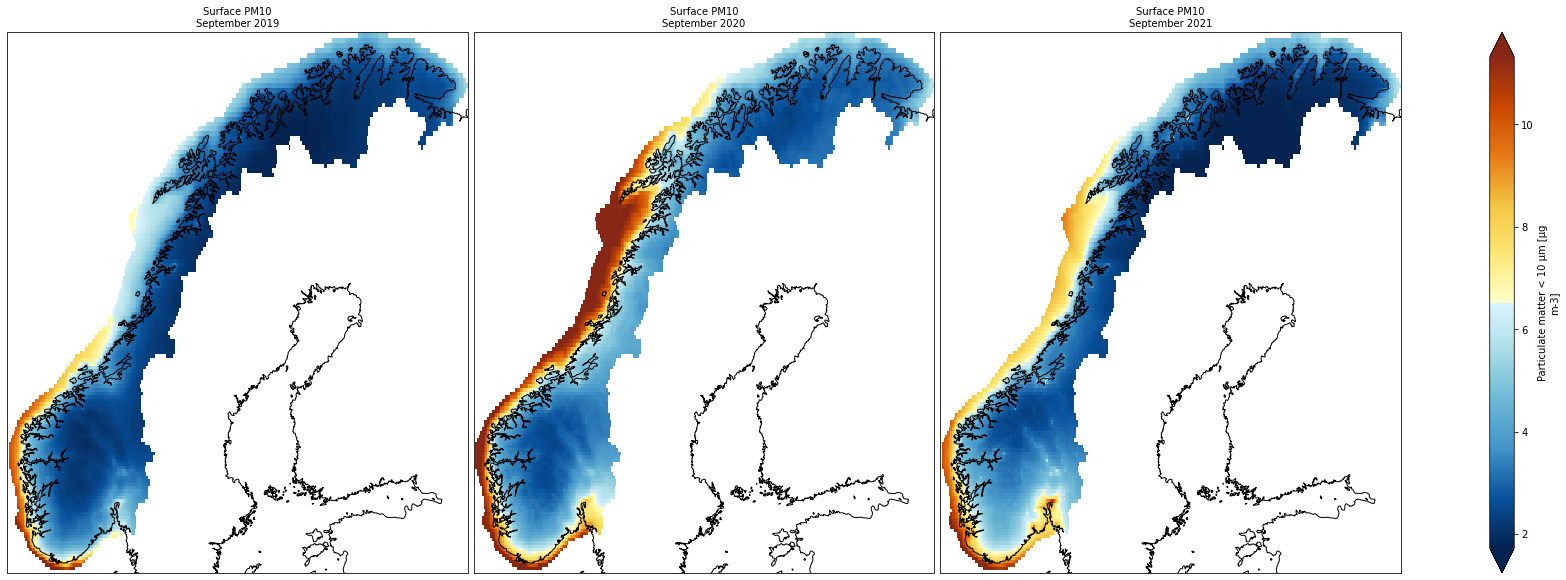

In [51]:
# generate figure
proj_plot = ccrs.Mercator(central_longitude=central_longitude)

lcmap = cmaps.BlueYellowRed
# Only plot values greater than 0
p = geotiff_dm[variable_name].where(geotiff_dm[variable_name] > 0).plot(x='longitude', y='latitude',
                                                                 transform=ccrs.PlateCarree(),
                                                                 subplot_kws={"projection": proj_plot},
                                                                 size=8,
                                                                 col='year', col_wrap=3, robust=True,
                                                                 cmap=lcmap, add_colorbar=True)

# We have to set the map's options on all four axes
for ax,i in zip(p.axes.flat,  geotiff_dm.year.values):
    ax.coastlines()
    ax.set_title('Surface ' + variable_name + '\n' + 'September ' + str(i), fontsize=10)

plot_file = os.path.join(OUTPUT_DATA_DIR, variable_name + '_september_' + country_code + '_2019-2021.png')
if os.path.exists(plot_file + '.bak'):
    os.remove(plot_file + '.bak')
if os.path.exists(plot_file):
    os.rename(plot_file, plot_file + '.bak') 
plt.savefig(plot_file)

#### Plot one single date

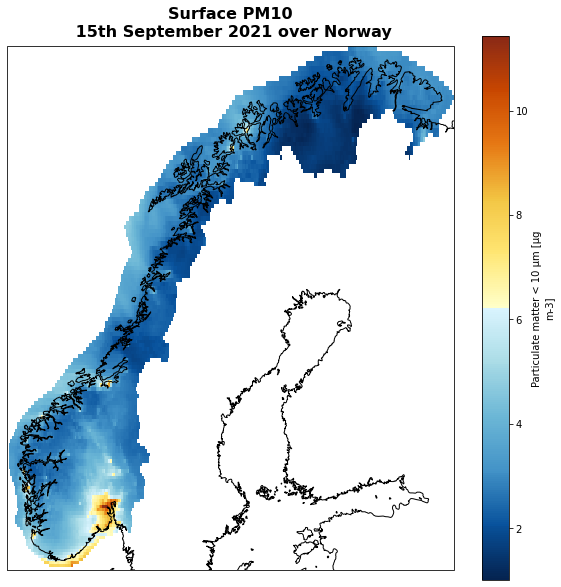

In [52]:
fig=plt.figure(figsize=(10,10))
# Define the projection
crs=ccrs.PlateCarree()

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=central_longitude))
ax.coastlines(resolution='10m')

# custom colormap

lcmap = cmaps.BlueYellowRed

# We need to project our data to the new Mercator projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
# we only plot values greather than 0
img = geotiff_ds[variable_name].where(geotiff_ds[variable_name] > 0).sel(time='2021-09-15').plot(ax=ax,
                                                                                                 transform=ccrs.PlateCarree(),
                                                                                                 cmap=lcmap)  

# Title for plot
plt.title('Surface ' + variable_name + '\n 15th September 2021 over ' + country_fullname,
          fontsize = 16, fontweight = 'bold', pad=10)

plot_file = os.path.join(OUTPUT_DATA_DIR, variable_name + '_september_' + country_code + '_2021-09-15.png')
if os.path.exists(plot_file + '.bak'):
    os.remove(plot_file + '.bak')
if os.path.exists(plot_file):
    os.rename(plot_file, plot_file + '.bak')  
plt.savefig(plot_file)

#### Interactive plot with bokeh

In [53]:
import holoviews as hv
import hvplot.xarray

<div align="center">
    <h1 style="font-size:5vw">Interactive plot from 1st September to 30th September 2021</h1>
</div>

In [54]:
geotiff_ds = geotiff_ds.sortby('time')

In [55]:
plot_start_time = '2021-09-01'
plot_end_time = '2021-09-30'
labels = geotiff_ds.hvplot.labels( text_font_size='6pt', text_color='blue').opts(xoffset=20)
map_hv = geotiff_ds.where(geotiff_ds[variable_name] > 0).sel(time=slice(plot_start_time, plot_end_time))[variable_name].hvplot(
    groupby="time",
    cmap=lcmap,
    geo=True,
    coastline='10m',
    frame_width=400,
    clim=(0,35) 
)
plot_file = os.path.join(OUTPUT_DATA_DIR, "interactive_map_" + plot_start_time + "_" + plot_end_time + ".html")
if os.path.exists(plot_file + '.bak'):
    os.remove(plot_file + '.bak')
if os.path.exists(plot_file):
    os.rename(plot_file, plot_file + '.bak') 
hv.save(map_hv, plot_file, backend="bokeh")

#### Save Data Cube selection into netCDF

In [56]:
output_file = os.path.join(OUTPUT_DATA_DIR, variable_name + "_september_" + country_code + "_2019-2021.nc")
if os.path.exists(output_file + '.bak'):
    os.remove(output_file + '.bak')
if os.path.exists(output_file):
    os.rename(output_file, output_file + '.bak') 
geotiff_ds.to_netcdf(output_file)

#### Plot a timeseries

<div align="center">
    <h1 style="font-size:5vw">Timeseries from 1st September to 30th September 2021</h1>
</div>

Sort times and then select one location

In [57]:
# You may change this location accordingly
location = town_fullname
latitude = town_coordinates['latitude']
longitude = town_coordinates['longitude']
plot_end_time = '2021-09-01'
plot_end_time = '2021-09-30'

In [58]:
ts = geotiff_ds[variable_name].where(geotiff_ds[variable_name] > 0). \
        sel(latitude=latitude, longitude=longitude, method='nearest'). \
        sel(time=slice(plot_start_time, plot_end_time))

In [59]:
ts_plot = ts.hvplot(color='purple') * ts.hvplot.scatter(marker='o', color='blue', size=15)

In [60]:
ts_plot

:Overlay
   .Curve.I   :Curve   [time]   (PM10)
   .Scatter.I :Scatter   [time]   (PM10)

In [61]:
plot_file = os.path.join(OUTPUT_DATA_DIR, "interactive_timeseries_" + location + "_" + plot_start_time + "_" + plot_end_time + ".html")
if os.path.exists(plot_file + '.bak'):
    os.remove(plot_file + '.bak')
if os.path.exists(plot_file):
    os.rename(plot_file, plot_file + '.bak') 
hv.save(ts_plot, plot_file, backend="bokeh")

#### Save timeseries into tabular (csv) file

In [62]:
output_file = os.path.join(OUTPUT_DATA_DIR, "timeseries_" + location + "_september2021.csv")
if os.path.exists(output_file + '.bak'):
    os.remove(output_file + '.bak')
if os.path.exists(output_file):
    os.rename(output_file, output_file + '.bak') 
ts.to_series().to_csv(output_file, sep='\t')

## <a id=7_rohub></a> **Step 7: Create Research Object and Share my work**

## Create Research Object in ROHUB

In [63]:
pip install rohub

Note: you may need to restart the kernel to use updated packages.


In [64]:
import os
import pathlib
from rohub import rohub, settings

#### Authenticating

- If the code cell below fails,  make sure you have created the two files:
    - `rohub-user`: contains your rohub username
    - `rohub-pwd`: contains your rohub password

In [65]:
rohub_user = open(os.path.join(os.environ['HOME'],"rohub-user")).read().rstrip()
rohub_pwd = open(os.path.join(os.environ['HOME'],"rohub-pwd")).read().rstrip()

In [66]:
rohub.login(username=rohub_user, password=rohub_pwd)

Logged successfully as annefou@geo.uio.no.


## Create a new Exectuable RO

In [67]:
ro_title =  variable_name + ' in ' + country_fullname + " Jupyter notebook demonstrating the usage of CAMS European air quality analysis from Copernicus Atmosphere Monitoring with RELIANCE services"
ro_research_areas = ["Earth sciences"]
ro_description = "This Research Object demonstrates how to use CAMS European air quality analysis from Copernicus Atmosphere Monitoring with RELIANCE services and compute monthly map of " + \
                 variable_name + "over a given geographical area, here " + country_fullname
ro = rohub.ros_create(title=ro_title, research_areas=ro_research_areas, 
                      description=ro_description, 
                      use_template=True,
                      ros_type="Executable Research Object")

Research Object was successfully created with id = a05fff1d-b9bd-4295-bf58-a33125a1d926


## Show metadata

In [68]:
ro.show_metadata()

{'identifier': 'a05fff1d-b9bd-4295-bf58-a33125a1d926',
 'shared_link': 'https://w3id.org/ro-id/a05fff1d-b9bd-4295-bf58-a33125a1d926',
 'title': 'PM10 in Norway Jupyter notebook demonstrating the usage of CAMS European air quality analysis from Copernicus Atmosphere Monitoring with RELIANCE services',
 'description': 'This Research Object demonstrates how to use CAMS European air quality analysis from Copernicus Atmosphere Monitoring with RELIANCE services and compute monthly map of PM10over a given geographical area, here Norway',
 'status': 'LIVE',
 'access_mode': 'PUBLIC',
 'type': 'Executable Research Object',
 'template': 'Executable Research Object folders structure',
 'created': '2022-01-23T21:00:01.007009Z',
 'creator': 'annefou@geo.uio.no',
 'modificator': None,
 'modified': '2022-01-23T21:00:01.477602Z',
 'importer': None,
 'research_areas': ['Earth sciences'],
 'owner': 'annefou@geo.uio.no',
 'editors': [],
 'readers': [],
 'rating': '0.00',
 'number_of_ratings': 0,
 'number_

## Add additional authors and/or contributors to our Research Object

In [69]:
ro.set_authors(agents=author_emails)

Agent: annefou@geo.uio.no recognized in the system.
Agent: jeani@uio.no recognized in the system.


[{'identifier': '62277187-0f2e-4320-a6b0-7fe467f1b1c1',
  'username': 'annefou@geo.uio.no',
  'name': 'annefou@geo.uio.no',
  'type': 'RohubUser',
  'display_name': 'Anne Fouilloux',
  'orcid_identifier': '0000-0002-1784-2920',
  'affiliation': 'Nordic e-Infrastructure Collaboration (NeIC)'},
 {'identifier': '1ac03644-c78c-4ca2-b0b4-2d9e40f671af',
  'username': 'jeani@uio.no',
  'name': 'jeani@uio.no',
  'type': 'ExternalUser',
  'display_name': 'Jean Iaquinta',
  'orcid_identifier': '0000-0002-8763-1643',
  'affiliation': 'UiO'}]

## Add publisher/copyright holder

- Use [Research Organization Registry (ROR)](https://ror.org/) to find the identifier of your organization

### Add publishers 

In [70]:
ro.set_publishers(agents=list_publishers)

Agent: {'org_id': 'http://www.uio.no/english/', 'display_name': 'University of Oslo', 'agent_type': 'organization', 'ror_identifier': '01xtthb56', 'organization_url': 'http://www.uio.no/english/'} recognized in the system.
Agent: {'org_id': 'https://neic.no/', 'display_name': 'Nordic e-Infrastructure Collaboration', 'agent_type': 'organization', 'ror_identifier': '04jcwf484', 'organization_url': 'https://neic.no/'} recognized in the system.


[{'identifier': '1d581e9d-25e2-4029-bdeb-6c055a0db8e4',
  'username': 'https://ror.org/01xtthb56',
  'name': 'https://ror.org/01xtthb56',
  'type': 'Organization',
  'display_name': 'University of Oslo'},
 {'identifier': 'fbd9bdcf-4a1d-4ae8-9a90-6b9ec5a3b8b2',
  'username': 'https://ror.org/04jcwf484',
  'name': 'https://ror.org/04jcwf484',
  'type': 'Organization',
  'display_name': 'Nordic e-Infrastructure Collaboration'}]

In [71]:
ro.set_copyright_holders(agents=list_copyright_holders)

Agent: {'org_id': 'http://www.uio.no/english/', 'display_name': 'University of Oslo', 'agent_type': 'organization', 'ror_identifier': '01xtthb56', 'organization_url': 'http://www.uio.no/english/'} recognized in the system.


[{'identifier': '1d581e9d-25e2-4029-bdeb-6c055a0db8e4',
  'username': 'https://ror.org/01xtthb56',
  'name': 'https://ror.org/01xtthb56',
  'type': 'Organization',
  'display_name': 'University of Oslo'}]

In [72]:
organizations = rohub.organizations_find()
organizations

identifier             organization_id  \
0  92459295-cc33-40a2-b2ca-e416ad73a95e        neworg_1@example.org   
1  556f3671-87b4-4576-b39d-654942ef248e        neworg_2@example.org   
2  fbd9bdcf-4a1d-4ae8-9a90-6b9ec5a3b8b2   https://ror.org/04jcwf484   
3  b1893a50-9f9b-49e8-8ab7-114152e29b9e            https://neic.no/   
4  64ec5402-1171-42f6-b9dd-6fa901ca9724   https://ror.org/025cj6e44   
5  f8b4ad0c-a4b1-4595-81a0-dcf42db083d4  http://www.uio.no/english/   
6  1d581e9d-25e2-4029-bdeb-6c055a0db8e4   https://ror.org/01xtthb56   

                                  display_name                 email  \
0                                Example Org 1   neworg1@example.org   
1                                Example Org 2   neworg2@example.org   
2        Nordic e-Infrastructure Collaboration                  None   
3        Nordic e-Infrastructure Collaboration                         
4  Poznan Supercomputing and Networking Center  office@man.poznan.pl   
5                           University of Oslo                         
6                           University of Oslo                  None   

                          url ror_identifier  
0  http://neworg1.example.org        abcd123  
1  http://neworg2.example.org        abcd123  
2            https://neic.no/      04jcwf484  
3            https://neic.no/      04jcwf484  
4        https://www.psnc.pl/      025cj6e44  
5  http://www.uio.no/english/      01xtthb56  
6  http://www.uio.no/english/      01xtthb56

## Add RO Funding information

In [73]:
if funded_by:
    ro.add_funding(grant_identifier=funded_by["grant_id"], grant_name=funded_by["grant_Name"],
                   funder_name=funded_by["funder_name"], grant_title=funded_by["grant_title"],
                   funder_doi=funded_by["funder_doi"])

## Add RO license

In [74]:
ro.set_license(license_id=license) 

{'identifier': 'MIT',
 'title': 'MIT License',
 'description': 'MIT License',
 'created': '2016-09-12T02:51:35.895509+00:00',
 'updated': '2021-10-07T08:21:23.483114+00:00',
 'creator': None,
 'status': 'active',
 'url': 'https://opensource.org/licenses/MIT',
 'custom': False}

## Aggregate Resources

- We will be adding all the resources generated by our notebook (data and plots)
- Our data and plots can also be shared in B2DROP so we will get the shared link from B2DROP and add it to our research object

### List RO folders for this type of RO

In [75]:
myfolders = ro.list_folders()
myfolders

identifier    name description  \
0  f98c07b8-d1bd-459d-9e71-1cd0204872c9  biblio        None   
1  93b17669-c7ba-43b1-969f-1ca3ea57c6cd   input        None   
2  2538e065-7c3b-48fa-b70e-f634e67a296f  output        None   
3  f0d89706-9965-46f7-8111-730b377913b2    tool        None   

              creator                       created_on  \
0  annefou@geo.uio.no  2022-01-23T21:00:01.687069+0000   
1  annefou@geo.uio.no  2022-01-23T21:00:01.687272+0000   
2  annefou@geo.uio.no  2022-01-23T21:00:01.687437+0000   
3  annefou@geo.uio.no  2022-01-23T21:00:01.687553+0000   

                       modified_on    path  
0  2022-01-23T21:00:01.689024+0000  biblio  
1  2022-01-23T21:00:01.689212+0000   input  
2  2022-01-23T21:00:01.689339+0000  output  
3  2022-01-23T21:00:01.689447+0000    tool

## Aggregate internal resources

### Add sketch to my RO

In [77]:
res_file_path = os.path.join(OUTPUT_DATA_DIR, variable_name + '_september_' + country_code + '_2019-2021.png')
res_res_type = "Sketch"
res_title = variable_long_name + " [" + variable_unit + "] over " + country_fullname + " for September 2019, 2020 and 2021"
res_description = "Monthly average maps of CAMS " + variable_long_name + " [" + variable_unit + "] over " + country_fullname + " in 2019, 2020 and 2021"
res_folder =  myfolders[myfolders['name'] == 'output'].iloc[0]['identifier']

ro.add_internal_resource(res_type=res_res_type, file_path=res_file_path, title=res_title, description=res_description, folder=res_folder)

Resource was successfully created with id = b93e0f67-148c-4427-8bf0-a485ecbddd74


Resource(identifier=b93e0f67-148c-4427-8bf0-a485ecbddd74, post_request=False)

## Aggregate external resources

###  Get shared link from datahub
1. Retrieve your client identifier, client secret and refresh token from https://aai.egi.eu/fedcloud/
2. Create a new file in your HOME area for instance using nano (keep the `$` character in front of HOME; this is meant to be an environment variable):
```
nano $HOME/egi_fedcloud.cfg
```
3. Paste your client identifier, client secret and refresh token using the following syntax (do not forget `{` and `}` as well as comma `,` and columns `:`
```
{
"id": "XXXXXXXXXXXXXXXXX",
"secret": "YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY",
"token": "ffffffffffffffffffffffff"
}
```
4. You are ready to go. If you have issues, check first that the syntax is correct in your egi_fedcloud.cfg, that this file is located in the correct folder and then finally that your refresh token is still valid (check on https://aai.egi.eu/fedcloud/)

In [78]:
import os
import json
import requests
import datetime
import shutil

#### EGI Datahub functions to initialize EGI datahub and get shared link

In [79]:
def egi_datahub_init():
    egi_fedcloud_filename = os.path.join(os.environ['HOME'], 'egi_fedcloud.cfg')
    with open(egi_fedcloud_filename, 'r') as convert_file:
        tmp = convert_file.read()
        egi_fedcloud_auth = json.loads(tmp)
        try:
            # Retrieving an OIDC token from Check-in
            data = {
                'client_id': egi_fedcloud_auth['id'],
                'client_secret': egi_fedcloud_auth['secret'],
                'refresh_token': egi_fedcloud_auth['token'],
                'scope': 'openid email profile',
                'grant_type': 'refresh_token'
            }
            response = requests.post('https://aai.egi.eu/oidc/token', data=data, auth=(egi_fedcloud_auth['id'], 
                                                                                       egi_fedcloud_auth['secret']))
            #print(json.dumps(response.json(), indent=2))
            EGItoken = response.json()['access_token']
            headers = {
                'X-Auth-Token': f"egi:" + EGItoken,
                'Content-type': 'application/json',
            }
            # get current timestamp
            ts = datetime.datetime.now().timestamp()
            data = json.dumps({ 
                'name': 'REST and CDMI access token ' + str(ts), 
                'type': { 
                    'accessToken': {} 
                }, 
                'caveats': [ { 
                    'type': 'interface', 
                    'interface': 'rest' 
                }] 
            })

            response = requests.post('https://datahub.egi.eu/api/v3/onezone/user/tokens/named', headers=headers, data=data)
            DATAHUB_TOKEN = response.json()['token']
            return DATAHUB_TOKEN
        except:
            print("EGI Datahub Authentication problem: check your credentials")

In [80]:
def egi_datahub_getlink(datahub_token, filename):
    bname = os.path.basename(filename)
    datahub_remote_prefix = 'https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/files/'
    hname = filename.split('datahub/')[1]
    datahub_location = os.path.join(datahub_remote_prefix, hname)
    print(datahub_location)
    headers = { 'X-Auth-Token': datahub_token }
    response = requests.get(datahub_location, headers=headers)
    dh_fileid = response.json()[0]['id']
    
    headers = { 'X-Auth-Token': datahub_token, 'Content-Type': 'application/json',}
    data = json.dumps({ 'name': bname,
    'fileId': dh_fileid
    })
    response = requests.post('https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/shares', headers=headers, data=data)
    # print(json.dumps(response.json(), indent=2))
    shareIdGenerated=response.json()['shareId']
    
    headers = {'X-Auth-Token': datahub_token}
    response = requests.get('https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/shares/'+shareIdGenerated, headers=headers) 
    # print(json.dumps(response.json(), indent=2))
    publicURL = response.json()['publicUrl']
    return publicURL

### EGI DataHub initialization 

In [81]:
DATAHUB_TOKEN = egi_datahub_init()

## Add inputs to my RO
- I used ADAM to retrieve relevant data but I will be sharing what I retrieved from the data cube so that my collaborators do not have to re-download the same input data again.

#### Geojson file used for rertieving data from ADAM data-cube

In [82]:
shared_input_path = os.path.join(INPUT_DATA_DIR, country_code.lower() + '.geo.json')
print(shared_input_path)
res_file_url = egi_datahub_getlink(DATAHUB_TOKEN, shared_input_path)
res_type = "Dataset"
res_title = "Geojson for " + country_fullname
res_description = "Geojson file used for retrieving data from the ADAM platform over " + country_fullname
res_folder = myfolders[myfolders['name'] == 'input'].iloc[0]['identifier']
ro.add_external_resource(res_type=res_type, input_url=res_file_url, title=res_title, description=res_description, folder=res_folder)

/home/jovyan/datahub/Reliance/Climate_NOR_PM10/input/nor.geo.json
https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/files/Reliance/Climate_NOR_PM10/input/nor.geo.json
Resource was successfully created with id = 3cfe7d67-79f7-4721-8a57-bf6a514ad5b4


Resource(identifier=3cfe7d67-79f7-4721-8a57-bf6a514ad5b4, post_request=False)

#### Input data retrieved from ADAM data-cube

In [83]:
for year in ['2019', '2020', '2021']:
    shared_input_path = os.path.join(INPUT_DATA_DIR, variable_name + '_' + country_code + '_ADAMAPI_' + year + '.zip')
    print(shared_input_path)
    res_file_url = egi_datahub_getlink(DATAHUB_TOKEN, shared_input_path)
    res_type = "Data Cube Product"
    res_title = "Data-Cube from ADAM platform over " + country_fullname + " in September " + year
    res_description = "This dataset is a data-Cube retrieved from the ADAM platform over " + country_fullname + " in September " + year
    res_folder = myfolders[myfolders['name'] == 'input'].iloc[0]['identifier']
    ro.add_external_resource(res_type=res_type, input_url=res_file_url, title=res_title, description=res_description, folder=res_folder)

/home/jovyan/datahub/Reliance/Climate_NOR_PM10/input/PM10_NOR_ADAMAPI_2019.zip
https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/files/Reliance/Climate_NOR_PM10/input/PM10_NOR_ADAMAPI_2019.zip
Resource was successfully created with id = 1191f2c0-7ec3-4f5d-bf3b-362debbeae24
/home/jovyan/datahub/Reliance/Climate_NOR_PM10/input/PM10_NOR_ADAMAPI_2020.zip
https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/files/Reliance/Climate_NOR_PM10/input/PM10_NOR_ADAMAPI_2020.zip
Resource was successfully created with id = b2f9e321-bd28-4e00-b733-1097c5008256
/home/jovyan/datahub/Reliance/Climate_NOR_PM10/input/PM10_NOR_ADAMAPI_2021.zip
https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/files/Reliance/Climate_NOR_PM10/input/PM10_NOR_ADAMAPI_2021.zip
Resource was successfully created with id = 7d16df8b-6b1b-4f34-9e6e-3d4a2dcb51e8


### Add our Jupyter Notebook to our RO
- Make a copy of the current notebook to the tool folder for sharing as an external resource

In [84]:
notebook_filename = 'RELIANCE_' + country_fullname + '_' + variable_name + '.ipynb'
local_notebook_path = os.path.join('./', notebook_filename)
shared_notebook_path = os.path.join(TOOL_DATA_DIR, notebook_filename)

In [85]:
shared_notebook_path

'/home/jovyan/datahub/Reliance/Climate_NOR_PM10/tool/RELIANCE_Norway_PM10.ipynb'

#### Copy current notebook to shared datahub 

In [86]:
bkfile = shared_notebook_path + '.bak'
if os.path.exists(bkfile):
    os.remove(bkfile)
if os.path.exists(shared_notebook_path):
    os.rename(shared_notebook_path, bkfile)
shutil.copy2(local_notebook_path, shared_notebook_path)

'/home/jovyan/datahub/Reliance/Climate_NOR_PM10/tool/RELIANCE_Norway_PM10.ipynb'

### Create a shared link for my Jupyter Notebook

#### Get public URL from EGI Datahub to share link in RO 

In [87]:
res_file_url = egi_datahub_getlink(DATAHUB_TOKEN, shared_notebook_path)
res_type = "Jupyter Notebook"
res_title = "Jupyter Notebook of CAMS European air quality analysis from Copernicus Atmosphere Monitoring with RELIANCE services - Applied over " + country_fullname + " and variable " + variable_long_name
res_description = "Jupyter Notebook for discovering, accessing and processing RELIANCE data cube, and creating a Research Object with results, and finally publish it in Zenodo"
res_folder = myfolders[myfolders['name'] == 'tool'].iloc[0]['identifier']
ro.add_external_resource(res_type=res_type, input_url=res_file_url, title=res_title, description=res_description, folder=res_folder)

https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/files/Reliance/Climate_NOR_PM10/tool/RELIANCE_Norway_PM10.ipynb
Resource was successfully created with id = a5e8972d-a447-471a-9e97-d8caba6fabc9


Resource(identifier=a5e8972d-a447-471a-9e97-d8caba6fabc9, post_request=False)

#### Add first plot as Image to my Research Object (external resource from EGI Datahub)

In [88]:
shared_plot_path = os.path.join(OUTPUT_DATA_DIR, variable_name + '_september_' + country_code + '_2019-2021.png')
print(shared_plot_path)
res_file_url = egi_datahub_getlink(DATAHUB_TOKEN, shared_plot_path)
res_type = "Image"
res_title = variable_long_name + " [" + variable_unit + "] over " + country_fullname + " for September 2019, 2020 and 2021"
res_description = "Monthly average maps of CAMS " + variable_long_name + " [" + variable_unit + "] over " + country_fullname + " in 2019, 2020 and 2021"
res_folder = myfolders[myfolders['name'] == 'output'].iloc[0]['identifier']
ro.add_external_resource(res_type=res_type, input_url=res_file_url, title=res_title, description=res_description, folder=res_folder)

/home/jovyan/datahub/Reliance/Climate_NOR_PM10/output/PM10_september_NOR_2019-2021.png
https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/files/Reliance/Climate_NOR_PM10/output/PM10_september_NOR_2019-2021.png
Resource was successfully created with id = 24f97226-065f-4873-b530-6f770841a0e3


Resource(identifier=24f97226-065f-4873-b530-6f770841a0e3, post_request=False)

#### Add second plot as Image to my Research Object (external resource from EGI Datahub)

In [89]:
shared_plot_path = os.path.join(OUTPUT_DATA_DIR, variable_name + '_september_' + country_code + '_2021-09-15.png')
res_file_url = egi_datahub_getlink(DATAHUB_TOKEN, shared_plot_path)
res_type = "Image"
res_title = variable_long_name + " [" + variable_unit + "] over " + country_fullname + " on September 15, 2021"
res_description="Daily average maps of CAMS " + variable_long_name + variable_unit + "] over " + country_fullname + " on September 15, 2021"
ro.add_external_resource(res_type=res_type, input_url=res_file_url, title=res_title, description=res_description, folder=res_folder)

https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/files/Reliance/Climate_NOR_PM10/output/PM10_september_NOR_2021-09-15.png
Resource was successfully created with id = 6a57ca2d-994d-4b84-8528-60767adecfda


Resource(identifier=6a57ca2d-994d-4b84-8528-60767adecfda, post_request=False)

#### Add timeseries for the town (external resource from EGI Datahub)

In [90]:
shared_plot_path = os.path.join(OUTPUT_DATA_DIR, 'timeseries_' + town_fullname + '_september2021.csv')
res_file_url = egi_datahub_getlink(DATAHUB_TOKEN, shared_plot_path)
res_type="Result"
res_title="Timeseries of " + variable_long_name + " [" + variable_unit + "] over " + town_fullname + " in september 2021"
res_description="Daily average of CAMS " + variable_long_name + variable_unit + "] over " + town_fullname + " in September 2021"
ro.add_external_resource(res_type=res_type, input_url=res_file_url, title=res_title, description=res_description, folder=res_folder)

https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/files/Reliance/Climate_NOR_PM10/output/timeseries_Oslo_september2021.csv
Resource was successfully created with id = 490ce52b-39c2-43c5-9d10-defb9662b454


Resource(identifier=490ce52b-39c2-43c5-9d10-defb9662b454, post_request=False)

#### Add netCDF file corresponding to Data cube selection (external resource from EGI Datahub)

In [91]:
shared_plot_path = os.path.join(OUTPUT_DATA_DIR, variable_name + '_september_' + country_code + '_2019-2021.nc')
res_file_url = egi_datahub_getlink(DATAHUB_TOKEN, shared_plot_path)
res_type="Result"
res_title="netCDF data for daily " + variable_name + "over " + country_fullname + " in September 2019, 2020 and 2021"
res_description="netCDF data corresponding to daily average of CAMS " + variable_long_name + " [" + variable_unit + "] over " + country_fullname + " for September 2019, September 2020 and September 2021"
ro.add_external_resource(res_type=res_type, input_url=res_file_url, title=res_title, description=res_description, folder=res_folder)

https://cesnet-oneprovider-01.datahub.egi.eu/api/v3/oneprovider/files/Reliance/Climate_NOR_PM10/output/PM10_september_NOR_2019-2021.nc
Resource was successfully created with id = 7acf667f-8185-4488-bb6d-1df425c492be


Resource(identifier=7acf667f-8185-4488-bb6d-1df425c492be, post_request=False)

## Additional metadata for the RO

### Add geolocation to my Research Object
- We need to transform our geojson file into geojson-ld

In [92]:
from geojson_rewind import rewind
import json

In [93]:
geojson_ld_file = os.path.join(INPUT_DATA_DIR, country_code.lower() + '.geo-ld.json')
bkfile = geojson_ld_file + '.bak'
if os.path.exists(bkfile):
    os.remove(bkfile)
if os.path.exists(geojson_ld_file):
    os.rename(geojson_ld_file, bkfile)
shutil.copy2(os.path.join(INPUT_DATA_DIR, country_code.lower() + '.geo.json'), geojson_ld_file)

with open(geojson_ld_file , 'r+') as f:
    data = json.load(f)
    output = rewind(data)
    output['@context'] = { "geojson": "https://purl.org/geojson/vocab#" } 
    f.seek(0)        
    json.dump(output, f, indent=None)
    f.truncate()

In [94]:
geolocation_file_path = os.path.join(INPUT_DATA_DIR, country_code.lower() + '.geo.json')
ro.add_geolocation(body_specification_json=geolocation_file_path)

[{'identifier': '745d6a20-f63b-4045-b76c-c3513e6bbac1',
  'shared_link': 'https://w3id.org/ro-id/a05fff1d-b9bd-4295-bf58-a33125a1d926/annotations/745d6a20-f63b-4045-b76c-c3513e6bbac1',
  'name': 'annotations/745d6a20-f63b-4045-b76c-c3513e6bbac1',
  'filename': '.ro/annotations/745d6a20-f63b-4045-b76c-c3513e6bbac1.ttl',
  'relation': False,
  'read_only': False,
  'target': 'a05fff1d-b9bd-4295-bf58-a33125a1d926',
  'ro': 'a05fff1d-b9bd-4295-bf58-a33125a1d926',
  'resources': [],
  'created': '2022-01-23T21:01:20.039014+0000',
  'creator': 'annefou@geo.uio.no',
  'modificator': None,
  'modified': '2022-01-23T21:01:20.038929+0000',
  'authors_credits': ['annefou@geo.uio.no'],
  'contributors_credits': [],
  'api_link': 'https://api.rohub.org/api/annotations/745d6a20-f63b-4045-b76c-c3513e6bbac1/'}]

### Export to RO-crate

In [95]:
ro.export_to_rocrate(filename="climate_EU-CAMS_" + country_code + "_" + variable_name + "_ro-crate", use_format="zip")

File was successfully downloaded.


### Take a snapshot of my RO

In [96]:
#snapshot_id=ro.snapshot()

### Archive and publish to Zenodo, optionally assign DOI 

In [97]:
snapshot_title="Jupyter Notebook Analysing the Air quality during Covid-19 pandemic using Copernicus Atmosphere Monitoring Service - Applied over " + country_fullname + " with " + variable_long_name
#snapshot_id_pub=ro.snapshot(title=snapshot_title, create_doi=True, publication_services=["Zenodo"])
#snapshot_id_pub

### Load the published Research Object

In [98]:
#published_ro = rohub.ros_load(identifier=snapshot_id)

### Show the DOI and get the link

In [99]:
#published_ro.show_publication()

### Fork and reuse existing RO to create derivative work

In [100]:
#fork_id=ro.fork(title="Forked Jupyter Notebook to analyze  the Air quality during Covid-19 pandemic using Copernicus Atmosphere Monitoring Service")
#forked_ro = rohub.ros_load(identifier=fork_id)
#forked_ro.show_metadata()